In [191]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
from scipy.stats import median_absolute_deviation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.auto import tqdm


# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]

In [192]:
def createWindows(win_len, fs, N_samp, overlap):
    win_len = win_len * fs
    overlap = np.round(overlap * win_len)
    N_samp = N_samp - win_len + 1
    
    idx_start = np.round(np.arange(0, N_samp, win_len - overlap)).astype(int)
    idx_stop = np.round(idx_start + win_len - 1).astype(int)
    
    return idx_start, idx_stop

In [193]:
def um(ta=None, tb=None, data=[[]], t=[]):
    length = len(data)
    ta = ta if ta else t.min()
    tb = tb if tb else t.max()
    twin = (t >= ta) & (t <= tb)

    plt.figure(dpi=100)
    for i, sig in enumerate(data):
        sig = np.ma.masked_invalid(sig)
        plt.subplot(length,1,i+1)
        plt.plot(t[twin], sig[twin], lw=1, c=cp[i])
        if ta != None:
            plt.xlim(ta, tb)
        plt.tight_layout()
        plt.show()

In [194]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

KeyboardInterrupt: 

In [ ]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/ECG_II']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))

Total 3238 cases found


In [ ]:
# Constants
fs = 125
MAX_LENGTH = 5

nan_threshold = 0.2
flat_line_threshold = 1E4


In [ ]:
def find_flat_lines(arr, threshold, type="art"):
    mean = np.mean(arr)
    std = np.std(arr)
    
    #valid_inds = np.where(np.abs(arr) < 3*mean)
    
    # Get the indices of the start and end of each flat line
    start_idx = np.where(np.abs((arr)) > 5)[0] + 1
    end_idx = np.concatenate(([0], start_idx[:-1]))
        

    # Compute the length of each flat line
    flat_line_lengths = start_idx - end_idx

    # Find flat lines longer than the threshold
    long_flat_lines = flat_line_lengths[flat_line_lengths > threshold]

    # Find the length of the longest flat line
    if len(long_flat_lines) > 0:
        longest_flat_line = np.max(long_flat_lines)
    else:
        longest_flat_line = 0

    # Count the number of flat lines longer than the threshold
    num_long_flat_lines = np.sum(flat_line_lengths > threshold)

    return longest_flat_line, num_long_flat_lines

In [ ]:
def load_data(vcaseid):    
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(vcaseid, track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    art, ppg = data[:, 1], data[:, 2]
    
    return t, art, ppg

In [ ]:
def hampel(x, k=5, t0=3):
    k = k if k % 2 == 1 else k + 1
    med = ss.medfilt(x, k)
    dev = np.abs(x - med)
    mdev = ss.medfilt(dev, k)
    return np.where(dev > t0 * mdev, med, x)

04/29/2023, 21:58:12: Processing subject 1456 of 3238
PPG NaNs: 0.0941412984970038. Consec PPG: 2478
PPG:
  Longest flat line: 145
  Number of flat lines longer than threshold: 1
ABP:
  Longest flat line: 0
  Number of flat lines longer than threshold: 0
2835


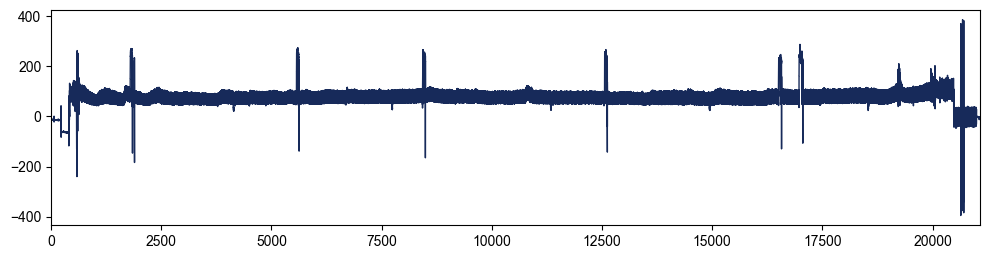

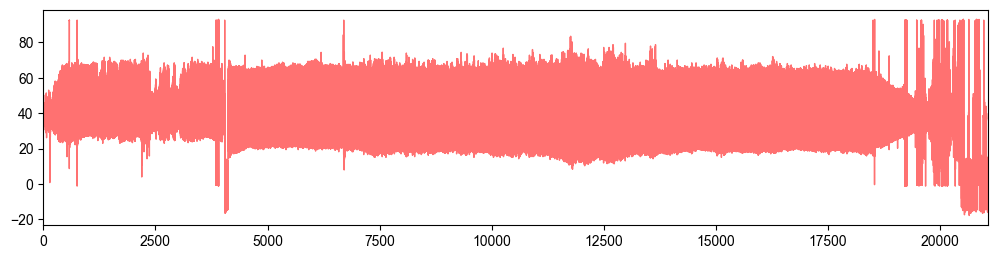

(1,)
04/29/2023, 21:58:20: Processing subject 2552 of 3238
PPG NaNs: 0.13468951520901132. Consec PPG: 2365
PPG:
  Longest flat line: 2365
  Number of flat lines longer than threshold: 1
ABP:
  Longest flat line: 2365
  Number of flat lines longer than threshold: 1
5043


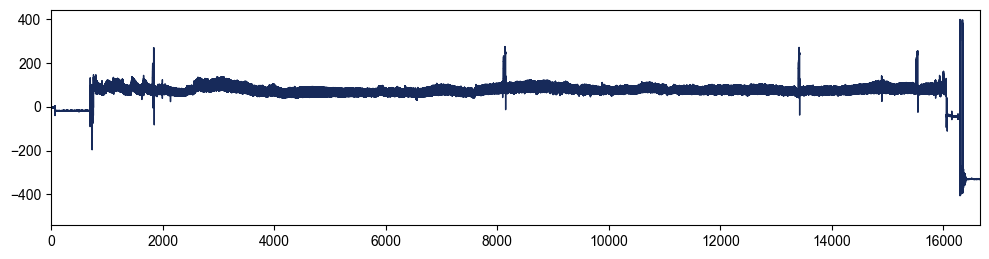

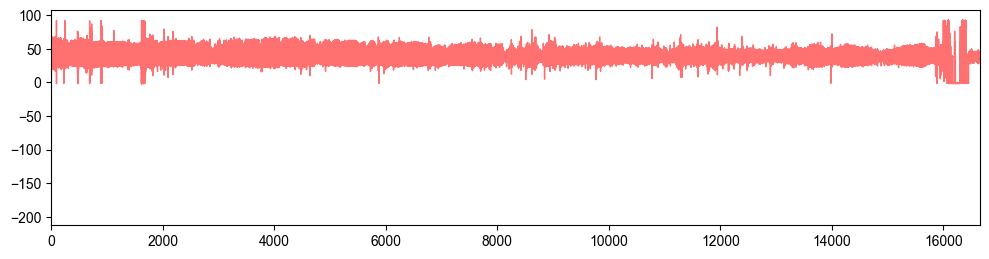

(2,)
04/29/2023, 21:58:26: Processing subject 658 of 3238
PPG NaNs: 0.007103736168121167. Consec PPG: 154
PPG:
  Longest flat line: 0
  Number of flat lines longer than threshold: 0
ABP:
  Longest flat line: 767
  Number of flat lines longer than threshold: 1
1277


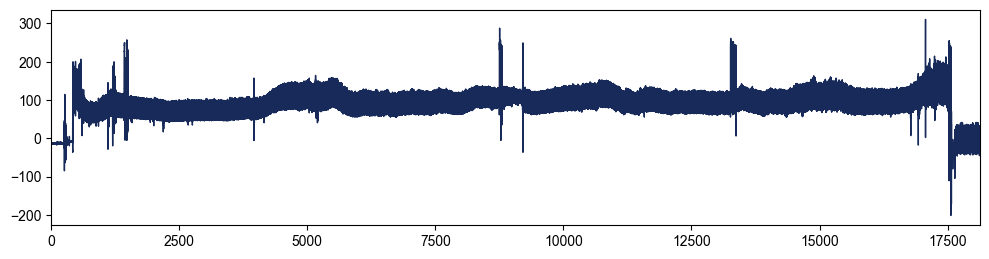

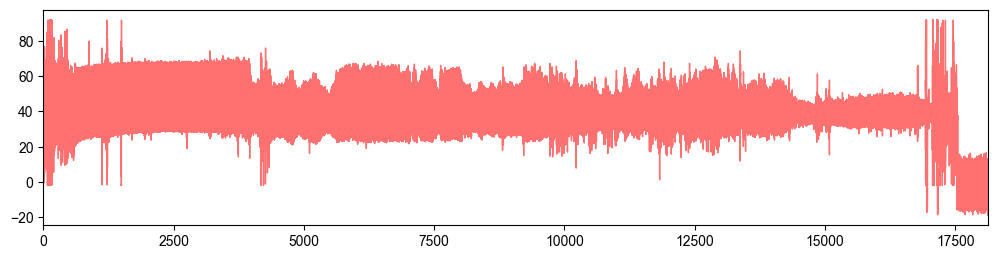

(3,)
04/29/2023, 21:58:32: Processing subject 412 of 3238
PPG NaNs: 0.007035712727525713. Consec PPG: 135
PPG:
  Longest flat line: 0
  Number of flat lines longer than threshold: 0
ABP:
  Longest flat line: 0
  Number of flat lines longer than threshold: 0
822


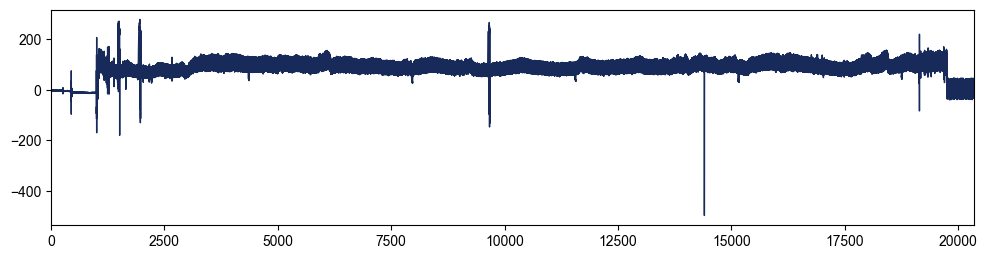

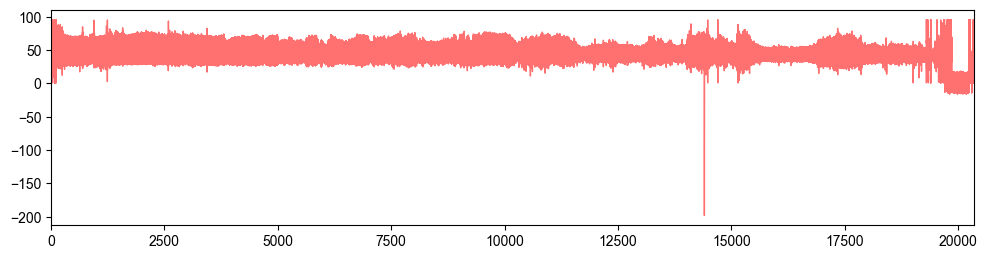

(4,)
04/29/2023, 21:58:40: Processing subject 2615 of 3238
PPG NaNs: 0.13383657774913785. Consec PPG: 2404
PPG:
  Longest flat line: 1246166
  Number of flat lines longer than threshold: 94
ABP:
  Longest flat line: 2404
  Number of flat lines longer than threshold: 5


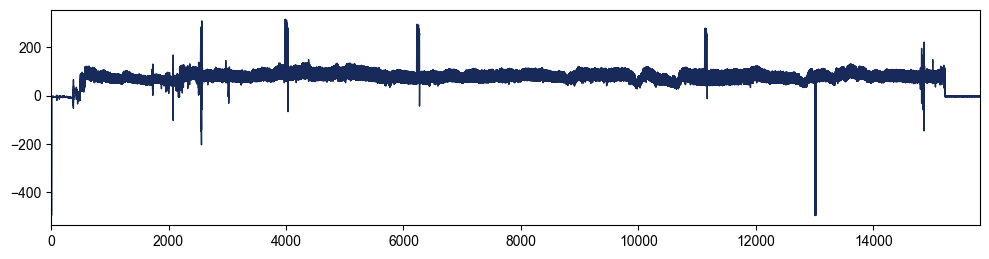

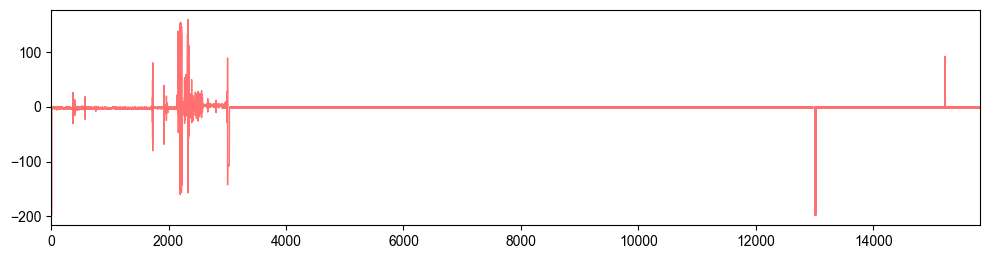

(4,)


In [ ]:
# Exclusion Checks
import random
#random_inds = random.sample(range(len(caseids)), MAX_LENGTH)
random_inds= [1456, 2552, 658, 412, 2615]
valid_caseids = []

for i in range(MAX_LENGTH):
    id = random_inds[i]
    vcaseid = caseids[id]
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {id} of {len(caseids)}',end='\n')
    
    t, art, ppg = load_data(vcaseid)
    
    # NaN check
    t_len = len(t)
    num_nans_ppg = np.isnan(ppg).sum() / t_len * 100
    
    ppg_nan_indices = np.where(~np.isnan(ppg))[0] - 1
    ppg_nan_lengths = np.diff(np.concatenate(([0], ppg_nan_indices, [t_len -1])))
    max_ppg_nan_length = np.max(ppg_nan_lengths)
    
    # print out max_art_nan_length, max_ppg_nan_length, num_nans_art / t_len, and num_nans ppg / t_len
    
    print(f'PPG NaNs: {num_nans_ppg}. Consec PPG: {max_ppg_nan_length}', end ='\n')
    
    # Check for flat lines in the signal
    longest_ppg, num_long_ppg = find_flat_lines(ppg[int(t_len * 0.125):int(t_len * 0.875)], 100)
    longest_art, num_long_art = find_flat_lines(art[int(t_len * 0.125):int(t_len * 0.875)], 100)        

    # Print the results
    print("PPG:")
    print("  Longest flat line:", longest_ppg)
    print("  Number of flat lines longer than threshold:", num_long_ppg)
    print("ABP:")
    print("  Longest flat line:", longest_art)
    print("  Number of flat lines longer than threshold:", num_long_art)
    
    if num_nans_ppg < nan_threshold and longest_ppg < flat_line_threshold and longest_art < flat_line_threshold:
        #Add checks here
        valid_caseids.append(id)
        print(vcaseid)
    
    um(ta=None, tb = None, data=[art, ppg], t=t)
    print(np.shape(valid_caseids))

In [ ]:
vcaseids= valid_caseids
vcaseids

[1456, 2552, 658, 412]

In [ ]:
def interpolate_fix(art, ppg):
    nan_indices = np.isnan(ppg)
    non_nan_indices = np.arange(len(ppg))[~nan_indices]
    non_nan_values_ppg = ppg[~nan_indices]
    non_nan_values_art = art[~nan_indices]
    
    interp_val_ppg = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_ppg)
    inter_val_art = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_art)
    
    ppg[nan_indices] = interp_val_ppg
    art[nan_indices] = inter_val_art
    
    return art, ppg

In [219]:
def processor_phase1(ppg=[], fs=125, window_size_mult = 10, art = True):
    
    window_size = int(window_size_mult*fs)
    
    ymin = minimum_filter1d(ppg, window_size)
    ymax = maximum_filter1d(ppg, window_size)

    ppgpeaks, _ = ss.find_peaks(ppg,
                                height=(ymax+ymin)/2,
                                prominence=(ymax-ymin)*0.3,
                                distance=fs/3)

    #blood pressure should be reasonable
    if art:
        valid = (ymin > 20) & (ymax < 300)
    else:
        valid = np.ones_like(ymin, dtype=bool)

    #Get the valid peaks here
    yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
    ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
    ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
    valid[ppgpeaks[ymindiff > 0.5]] = False
    valid[ppgpeaks[ymaxdiff > 0.5]] = False

    # Calculate the heart rate from r values
    rri = np.diff(ppgpeaks, prepend=0) / fs
    hr = 60/rri
    rriv = np.abs(np.diff(rri, append=0)) / rri

    # Reasonable heartrate check
    valid[ppgpeaks[hr < 30]] = False
    valid[ppgpeaks[rriv > 0.4]] = False
    
    #return the bit mask 
    return valid    

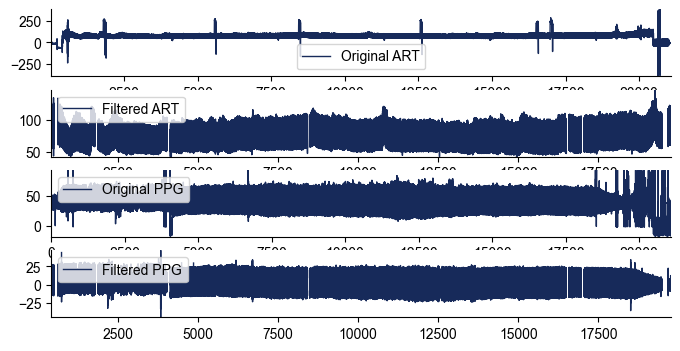

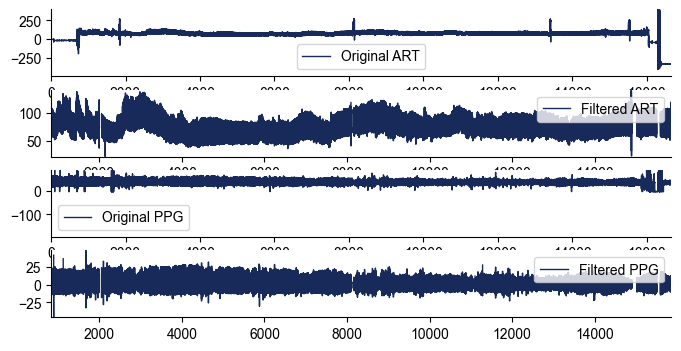

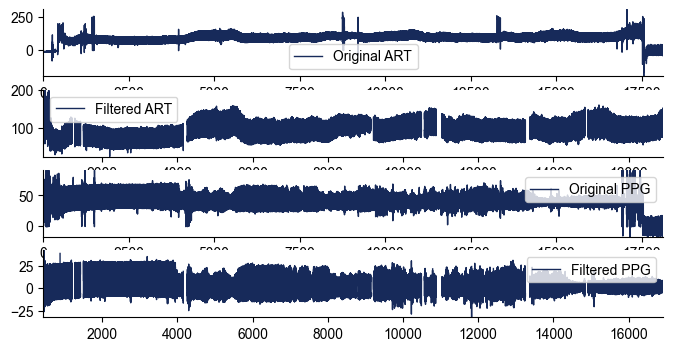

/Users/rohansanda/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


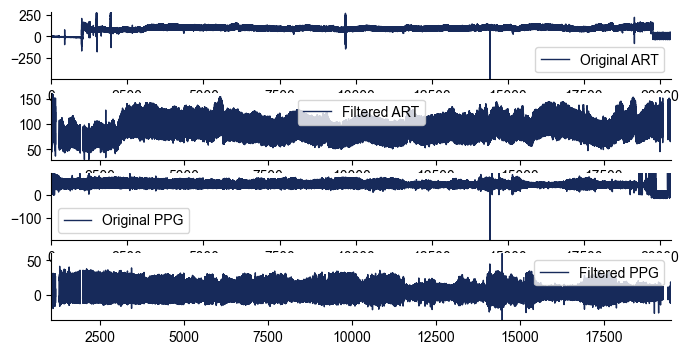

In [227]:
for id in vcaseids:
    vcaseid = caseids[id]
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(caseids[id], track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    art, ppg = data[:, 1], data[:, 2]
    
    nan_indices = np.isnan(ppg)
    non_nan_indices = np.arange(len(ppg))[~nan_indices]
    non_nan_values_ppg = ppg[~nan_indices]
    non_nan_values_art = art[~nan_indices]
    
    interp_val_ppg = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_ppg)
    inter_val_art = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_art)
    
    ppg[nan_indices] = interp_val_ppg
    art[nan_indices] = inter_val_art
    
    #um(ta=None, tb = None, data=[art, ppg], t=t)
    
    nyquist_freq = fs / 2
    cutoff_freq = [0.5, 8]  # Hz
    order = 4

    # Calculate filter coefficients
    b, a = ss.butter(order, [0.5 / nyquist_freq, 8 / nyquist_freq], btype='band')

    # Apply zero-phase filtering to PPG signal
    ppg_filt = ss.filtfilt(b, a, ppg)
    
    #art_filt = hampel(art, 100, 5)
    #um(ta=None, tb = None, data=[ppg_filt], t=t)
    
    ppg_mask = processor_phase1(ppg_filt, art=False)
    art_mask = processor_phase1(art)
        
    valid = ppg_mask & art_mask
    
    labels = np.cumsum(np.diff(valid, prepend=False))
    counts = np.bincount(labels)[labels]
    mask = valid & (counts > fs*61)                     #fs*61 is in the window length --> 61 second windows

    artm, ppgm = art.copy(), ppg_filt.copy()
    artm[~mask] = np.nan
    ppgm[~mask] = np.nan
    
    plt.figure(figsize=(8,4))
    plt.subplot(4,1,1)
    plt.plot(t, art, lw=1, label = "Original ART")
    #plt.xlim([0, len(ppg)])
    sns.despine()
    plt.gca().margins(0)
    plt.legend()

    plt.subplot(4,1,2)
    plt.plot(t, artm, lw=1, label = "Filtered ART")
    #plt.xlim([0, len(ppg)])
    sns.despine()
    plt.gca().margins(0)
    plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(t, ppg, lw=1, label = "Original PPG")
    #plt.xlim([0, len(ppg)])
    sns.despine()
    plt.gca().margins(0)
    plt.legend()
    
    plt.subplot(4,1,4)
    plt.plot(t, ppgm, lw=1, label = "Filtered PPG")
    #plt.xlim([0, len(ppg)])
    sns.despine()
    plt.gca().margins(0)
    plt.legend()
    
    plt.show()
    
    
    
    # Interpolate NA values
    
    

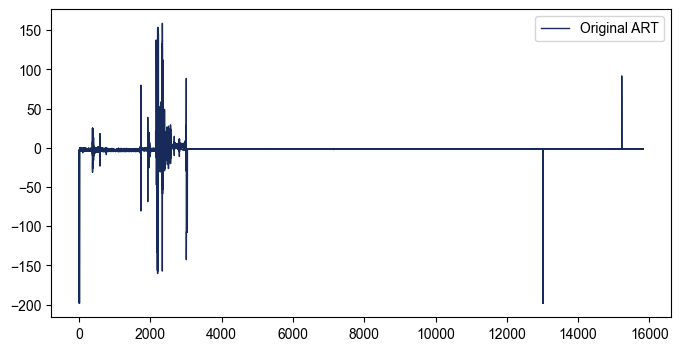

In [ ]:
track_names = ['ECG_II', 'ART', 'PLETH']
vf = vitaldb.VitalFile(caseids[vcaseids[4]], track_names) 
data = vf.to_numpy(track_names, 1/fs)
t = np.arange(data.shape[0]) / fs
    
art, ppg = data[:, 1], data[:, 2]

plt.figure(figsize=(8,4))
plt.plot(t, ppg, lw=1, label = "Original ART")
#plt.xlim([0, len(ppg)])
plt.legend()
plt.show()

#um(ta=None, tb = None, data=[art, ppg], t=t)

In [ ]:
data = np.array([ppg, art])
p_ppg, p_art = flat_lines(data, 15, False, True)

/var/folders/b_/17z8qb5d5sj2tcsvswmzlxs40000gn/T/ipykernel_40398/908624015.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  tmp_abp = (data[1, :len_data - window + 1] == data[1, i - 1:len_data - window + i - 1])
/var/folders/b_/17z8qb5d5sj2tcsvswmzlxs40000gn/T/ipykernel_40398/908624015.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  tmp_ppg = (data[0, :len_data - window + 1] == data[0, i - 1:len_data - window + i - 1])


TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

AttributeError: 'list' object has no attribute 'size'

In [ ]:
# Filtering

04/29/2023, 23:55:48: Processing subject 1 of 3238


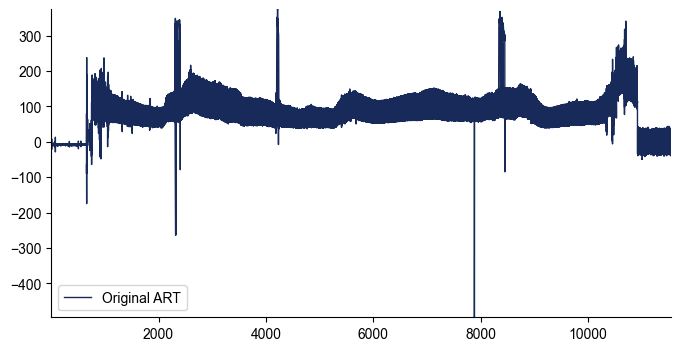

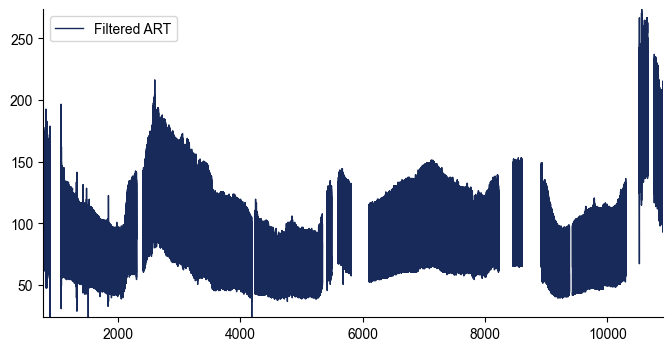

In [230]:
plots_on = True
debug_on = True
standard_processing = True

win_len = 100
fs = 125

PPG_RECORD = np.empty((0, int(win_len*fs)))
ECG_RECORD = np.empty((0, int(win_len*fs)))
ART_RECORD = np.empty((0, int(win_len*fs)))    

for id in range(1):
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {id + 1} of {len(caseids)}',end='\n')
    
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(caseids[id], track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    ecg, art, ppg = data[:, 0], data[:, 1], data[:, 2]
    
    #if plots_on:
    #    um(60*30, 60*31, [ecg, art, ppg], np.arange(len(ecg)/fs))
        
    N_samples = ecg.shape[0]
    win_start, win_stop = createWindows(win_len, fs, N_samples, 0)
    N_win = len(win_start)
    #N_samp_total += N_win
    
    #Parkers processing method
    if  ~standard_processing:
        ppg_mask = processor_phase1(ppg, art=False)
        art_mask = processor_phase1(art)
        
        valid = ppg_mask & art_mask
    
        labels = np.cumsum(np.diff(valid, prepend=False))
        counts = np.bincount(labels)[labels]
        mask = valid & (counts > fs*61)                     #fs*61 is in the window length --> 61 second windows

        artm, ppgm = art.copy(), ppg.copy()
        artm[~mask] = np.nan
        ppgm[~mask] = np.nan
        
        # for every continuous chunk of 1s in mask, turn that chunk into its own array and store all the chunks into a list
        
        
        #print(f'Num NaNs in Valid: {len(mask) - np.sum(mask)}. Num Nans in signal = {np.count_nonzero(np.isnan(artm))}', end ='\n')
        
        artm, ppgm = art.copy(), ppg.copy()
        artm[~mask] = np.nan
        ppgm[~mask] = np.nan


        chunked_artm, chunked_ppgm = [], []

        # Get indices where the mask switches between 0s and 1s
        switch_indices = np.concatenate(([0], np.where(np.diff(mask.astype(int)) != 0)[0] + 1, [len(mask)]))

        # Iterate over chunks of the mask with value 1 and extract the corresponding chunks from artm and ppgm
        for i in range(len(switch_indices) - 1):
            start_idx, end_idx = switch_indices[i], switch_indices[i + 1]
            if mask[start_idx] == 1:
                chunked_artm.append(artm[start_idx:end_idx])
                chunked_ppgm.append(ppgm[start_idx:end_idx])
 
        if plots_on:
            plt.figure(figsize=(8,4))
            plt.plot(t, art, lw=1, label = "Original ART")
            #plt.xlim([0, len(ppg)])
            sns.despine()
            plt.gca().margins(0)
            plt.legend()

            plt.figure(figsize=(8,4))
            plt.plot(t, artm, lw=1, label="Filtered ART")
            #plt.plot(artm[int(0.18E6):int(0.33E6)], lw=1, label = "Filtered ART")
            #plt.xlim([0, len(ppg)])
            sns.despine()
            plt.gca().margins(0)
            plt.legend()
            plt.show()
             
    # Start the extraction process here
    # filtered ppg = ppgm
    # filtered art = artm
    # both are the same length and have the same NaN regions
    # fs = 125  
    
    # Goals:
    # Extract continuous non NaN segments form the PPG and ART signals
        
    
    

21


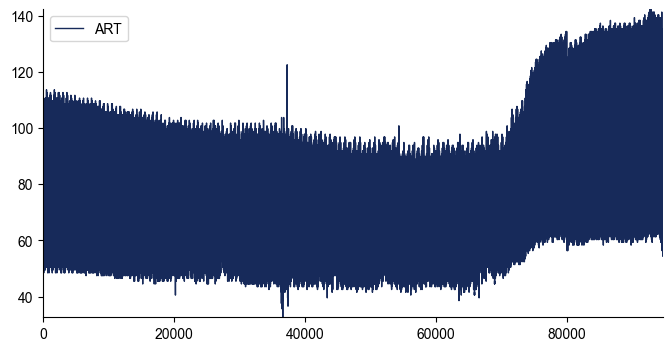

In [231]:
plt.figure(figsize=(8,4))
plt.plot(chunked_artm[3], lw=1, label =  "ART")
sns.despine()
plt.gca().margins(0)
plt.legend()

print(len(chunked_artm))

In [241]:
import matplotlib.pyplot as plt

def segment_ppg(ppg, fs=125, cycle_len=8):
    # Compute the number of samples in a cycle
    cycle_size = int(cycle_len * fs)
    
    # Compute the number of cycles
    num_cycles = len(ppg) // cycle_size
    
    # Reshape the PPG signal into a 2D array with one row per cycle
    ppg_cycles = ppg[:num_cycles*cycle_size].reshape(-1, cycle_size)
    
    # Plot the first five cycles
    fig, axs = plt.subplots(nrows=5, figsize=(10, 15))
    for i, ax in enumerate(axs):
        ax.plot(ppg_cycles[i])
        ax.set_title(f"Cycle {i+1}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Return the segmented PPG signal
    return ppg_cycles


In [257]:
def segment_ppg2(ppg, fs):
    # Find PPG peaks
    peaks, _ = ss.find_peaks(ppg, distance=int(0.5*fs))

    # Initialize variables
    cycles = []
    window_size = 0
    prev_peak = 0
    
    # Loop through peaks and segment cycles
    for i, peak in enumerate(peaks):
        # Determine window size based on previous cycle duration
        if i > 0:
            window_size = int((peak - prev_peak) * 1.5)
        # If first peak, use a fixed window size
        else:
            window_size = int(0.8*fs)
        
        # Segment current cycle
        start = peak - window_size//2
        end = peak + window_size//2
        if start < 0:
            start = 0
        if end > len(ppg)-1:
            end = len(ppg)-1
        cycle = ppg[start:end]
        
        # Append cycle to list
        cycles.append(cycle)
        
        # Update previous peak
        prev_peak = peak
    
    # Plot the first five cycles
    fig, axs = plt.subplots(nrows=10, figsize=(10, 15))
    for i, ax in enumerate(axs):
        ax.plot(cycles[i+100])
        ax.set_title(f"Cycle {i+1}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
        
    # Return cycles
    return cycles


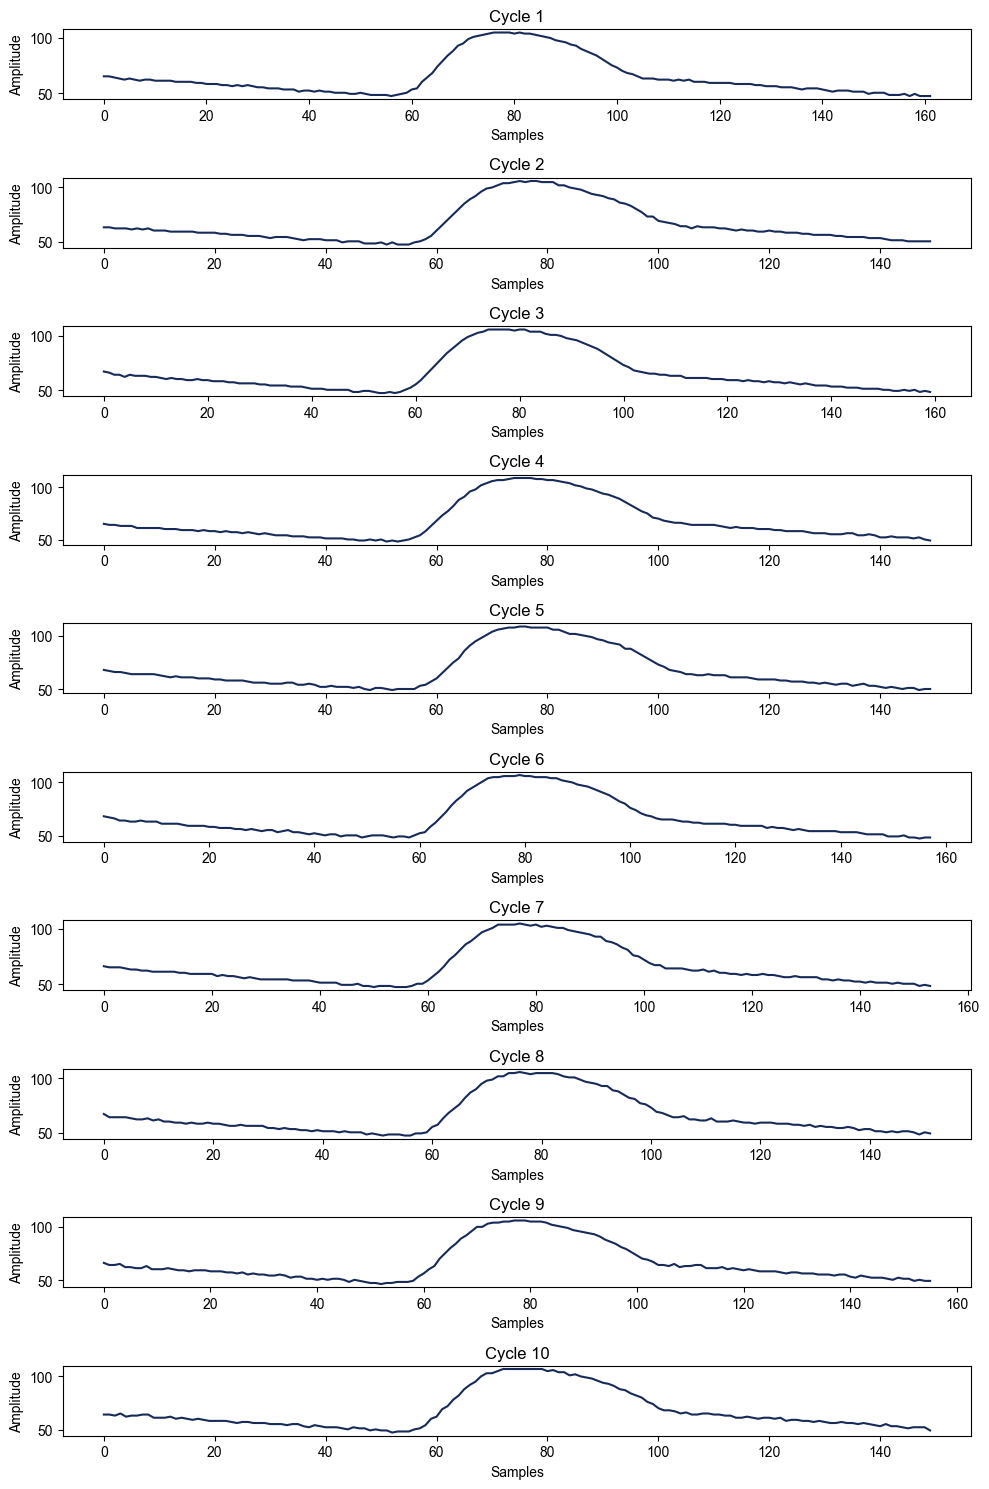

In [258]:
cycles = segment_ppg2(chunked_artm[3], fs)

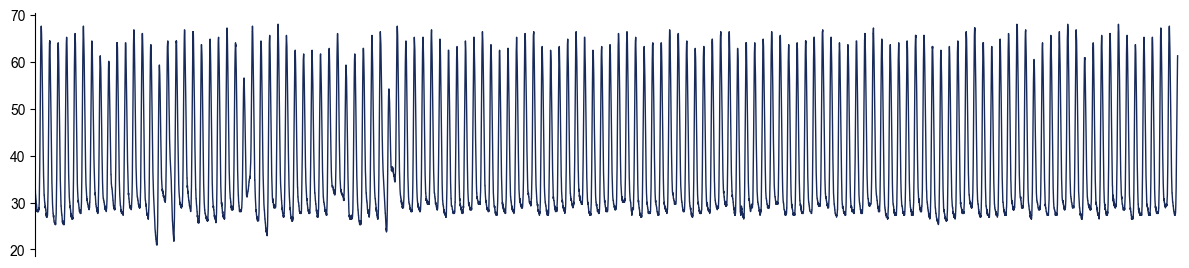

In [44]:
um(data=[PPG_RECORD[100, :]], t=np.arange(PPG_RECORD.shape[1])/fs)

In [25]:
ppg = PPG_RECORD[10, :]

In [24]:
if np.any(np.isnan(test_data)):
    print("Nan found")
    test_data = np.nan_to_num(test_data, nan=0.0, posinf=None, neginf=None)

else:
    print("No Nan found")

No Nan found


In [31]:
ymin = minimum_filter1d(ppg, int(fs*10))
ymax = maximum_filter1d(ppg, int(fs*10))

ppgpeaks, _ = ss.find_peaks(ppg,
                            height=(ymax+ymin)/2,
                            prominence=(ymax-ymin)*0.3,
                            distance=fs/3)

valid = (ymin > 20) & (ymax < 300)

yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
valid[ppgpeaks[ymindiff > 0.3]] = False
valid[ppgpeaks[ymaxdiff > 0.3]] = False

rri = np.diff(ppgpeaks, prepend=0) / fs
hr = 60/rri
rriv = np.abs(np.diff(rri, append=0)) / rri

valid[ppgpeaks[hr < 30]] = False
valid[ppgpeaks[rriv > 0.4]] = False

labels = np.cumsum(np.diff(valid, prepend=False))
counts = np.bincount(labels)[labels]
mask = valid & (counts > fs*61)

ppgm = ppg.copy()
ppgm[~mask] = np.nan

# find the number of nans in ppgm
print(np.isnan(ppgm).sum())


82


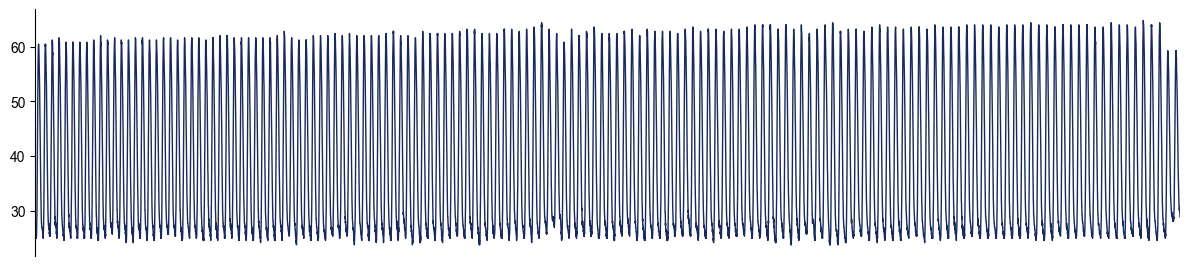

In [30]:
um(data=[PPG_RECORD[10, :]], t=np.arange(PPG_RECORD.shape[1])/fs)

82


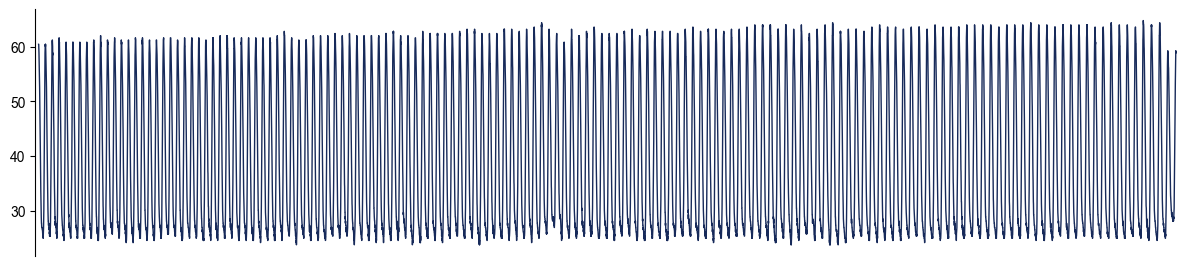

In [34]:
um(data=[check_heart_rate(ppg, 125)], t=np.arange(PPG_RECORD.shape[1])/fs)

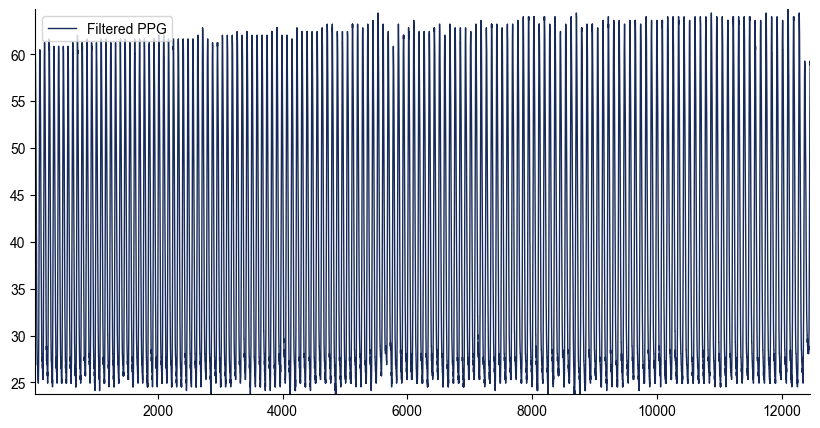

In [28]:
plt.plot(ppgm, lw=1, label = "Filtered PPG")
#plt.plot(t, artm, lw=1, label = "Filtered")
sns.despine()
plt.gca().margins(0)
plt.legend()